In [243]:
"""
This file is a collection of all the graphing & prediction code i have used in my bachelors project.
"""

import cv2
import pandas as pd
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from typing import Optional, List, Tuple

import torch
from torchvision import transforms
from torchmetrics.classification import JaccardIndex, MulticlassAccuracy
from torchmetrics.classification import MulticlassConfusionMatrix
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch.nn.functional as F
from empatches import BatchPatching

from skimage import exposure
import numpy as np
import cv2
from skimage.morphology import disk, square
from skimage.filters import median

import os
from imutils import paths
from files import config
from scipy.optimize import minimize

file_path = os.getcwd()

In [244]:
# Plotting guide for colorblind friendliness
# https://www.researchgate.net/profile/Mafalda-Ferreira-10/publication/313657827_The_Information_Visualization_Thematic_Head_to_Head_with_Color_Blindness/links/58a1c19da6fdccf5e970e999/The-Information-Visualization-Thematic-Head-to-Head-with-Color-Blindness.pdf
# https://www.mdpi.com/2072-4292/11/15/1762
#Plotting for the visualization of the model oil spills
# Plotting guide for colorblind friendliness
# https://www.researchgate.net/profile/Mafalda-Ferreira-10/publication/313657827_The_Information_Visualization_Thematic_Head_to_Head_with_Color_Blindness/links/58a1c19da6fdccf5e970e999/The-Information-Visualization-Thematic-Head-to-Head-with-Color-Blindness.pdf
# https://www.mdpi.com/2072-4292/11/15/1762
#Plotting for the visualization of the model oil spills
def prepare_plot(origImage, origMask, predMask, conf):
    grid = np.ones(len(origImage),)
    grid[len(origImage)-1] = 1.14
    figure, ax = plt.subplots(nrows=len(origImage), ncols=4, figsize=(18*len(origImage), 65), gridspec_kw={'height_ratios': grid})
    cmap = mcolors.ListedColormap(['black', 'blue', 'indianred', 'wheat', 'darkgreen'])
    cmap_diff = mcolors.ListedColormap(['lime', 'crimson', 'black'])
    norm = Normalize(vmin=0.0, vmax=4.0)
    norm_diff = Normalize(vmin=0.0, vmax=2.0)
    cmap_white = mcolors.ListedColormap(['white'])
    for i in range(len(origImage)):
        predMask[i] = predMask[i].squeeze()
        if i == 0:
            ax[i, 0].set_title(f"(a) Original Image", fontsize=72)
            ax[i, 1].set_title(f"(b) Original Mask", fontsize=72)
            ax[i, 2].set_title(f"(c) Predicted Mask", fontsize=72)
            ax[i, 3].set_title(f"(d) Difference Mask", fontsize=72)
        
        cb_og = ax[i, 0].imshow(origImage[i], cmap=cmap_white)
        
        ax[i, 0].axis('off')

        cab = ax[i, 1].imshow(origMask[i], cmap=cmap, norm=norm)
        
        ax[i, 1].axis('off')

        cb = ax[i, 2].imshow(predMask[i], cmap=cmap, norm=norm)
        ax[i, 2].axis('off')
        

        diffMask = origMask[i] - predMask[i]
        Negatives = np.where(diffMask != 0)
        diffMask[Negatives] = 1
        Background = (diffMask == 0) & (origMask[i] == 0)
        Background = np.where(Background)
        diffMask[Background] = 2
        
        cb_diff = ax[i, 3].imshow(diffMask, cmap=cmap_diff, norm=norm_diff)
        ax[i, 3].axis('off')
        

        if i == len(origImage) - 1:
            cbar = figure.colorbar(cab, ax=ax[i, 1], ticks=[0.4, 1.2, 2, 2.7, 3.6], pad=0.0025, shrink=0.95, orientation='horizontal', location='bottom')
            cbarc = figure.colorbar(cb, ax=ax[i, 2], ticks=[0.4, 1.2, 2, 2.7, 3.6], pad=0.0025, shrink=0.95, orientation='horizontal', location='bottom')
            cbar_alpha = figure.colorbar(cb_og, ax=ax[i, 0], ticks=[], alpha=0, pad=0.0025, shrink=0.95, orientation='horizontal', location='bottom')  # Invisible colorbar
            cbar_diff = figure.colorbar(cb_diff, ax=ax[i, 3], ticks=[0.35, 0.8, 1.7], pad=0, shrink=0.95, orientation='horizontal', location='bottom')
            cbar.ax.set_xticklabels(['Sea', 'Oil', 'LoA', 'Ship', 'Land'], fontsize=56, rotation=0)
            cbarc.ax.set_xticklabels(['Sea', 'Oil', 'LoA', 'Ship', 'Land'], fontsize=56, rotation=0)
            cbar_diff.ax.set_xticklabels(['True', 'False', 'Sea'], fontsize=56, rotation=0)
    plt.tight_layout()
    plt.show()

    figure, ax = plt.subplots(nrows=int(len(origImage) / 2), ncols=4, figsize=(50, 35), gridspec_kw={'width_ratios': [1, 2.34, 1, 2.34]})
    cmap = mcolors.ListedColormap(['white', 'blue', 'maroon', 'black', 'darkgreen'])
    norm = Normalize(vmin=0.0, vmax=4.0)
    n = 0

    for j in range(int(len(origImage) / 2)):
        for i in range(2):
            predMask[int(n)] = predMask[n].squeeze()

            ax[j, 1 + int(2 * i)].imshow(origImage[n])
            ax[j, 1 + int(2 * i)].set_title(f"Original Image with Prediction mask ({1 + n})", fontsize=32)
            ax[j, 1 + int(2 * i)].axis('off')

            cb = ax[j, 1 + int(2 * i)].imshow(predMask[n], interpolation="none", cmap=cmap, norm=norm, alpha=0.5)
            cbar = figure.colorbar(cb, ax=ax[j, 1 + int(2 * i)], ticks=[0.4, 1.2, 2, 2.8, 3.6], pad=0.025, shrink=0.9)
            cbar.ax.set_yticklabels(['Sea', 'Oil', 'LoA', 'Ship', 'Land'], fontsize=20)

            conf[n].plot(ax=ax[j, int(2 * i)], labels=['Sea', 'Oil', 'LoA', 'Ship', 'Land'], fontsize=35)
            n += 1

    figure.suptitle('DeepLabV3 predictions overlayed onto image with Prediction mask with corresponding confusionmatrix', fontsize=40, fontweight="bold")
    figure.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

#Prediction of the model for the visualization
def make_predictions(model, imagePath):

    # Initialize evaluation metrics
    ConfusionMatrix = MulticlassConfusionMatrix(num_classes=5, normalize="true").to(config.device)
    metric = JaccardIndex(task="multiclass", num_classes=5, average=None).to(config.device)
    Accuracy = MulticlassAccuracy(num_classes=5, average=None).to(config.device)
    preprocess_input = get_preprocessing_fn('resnet101', pretrained='imagenet')

    # Disable gradient calculation
    with torch.no_grad():

        # Get ground truth mask path
        filename = os.path.join(os.path.dirname(os.path.dirname(imagePath)), "labels_1D", os.path.splitext(os.path.basename(imagePath))[0] + ".png")
        groundTruthPath = os.path.join(file_path, config.train_label, filename)

        # Read image and ground truth mask
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gtMask = Image.open(groundTruthPath)

        # Set model to evaluation mode
        model.eval()

        # Convert image to PyTorch tensor
        image = transforms.ToTensor()(image).type(torch.float)
        x = torch.unsqueeze(image, dim=0)

        # Calculate the amount of padding needed
        target_height = ((x.size(2) + 31) // 32) * 32
        target_width = ((x.size(3) + 31) // 32) * 32
        padding_height = target_height - x.size(2)
        padding_width = target_width - x.size(3)

        # Apply zero-padding
        padded_image = F.pad(x, (0, padding_width, 0, padding_height))
        resized_image = transforms.Resize((target_height, target_width))(x)

        #print(padded_image.size())

        #################EMPATCHES
        """  bp = BatchPatching(patchsize=320, overlap=0.2, stride=None, typ='torch')
        # extracging
        print(x.size())
        batch_patches, batch_indices = bp.patch_batch(x)
        print(batch_patches[0][0].size())
        for i, patch in enumerate(batch_patches[0]):
            patch = torch.unsqueeze(patch.permute(2,0,1), dim=0)
            m = model(patch.to(config.device)).cpu()
            batch_patches[0][i] = torch.squeeze(m, dim=0).permute(1,2,0)
        
        merged_batch = bp.merge_batch(batch_patches, batch_indices, mode='overwrite')
        merged_batch = transforms.ToTensor()(merged_batch)
        #predMask = model(im)"""
        ######


        # Resize image and ground truth mask
        #image = transforms.Resize((320, 320))(image)
        #gtMask = transforms.Resize((320, 320), interpolation=transforms.InterpolationMode.NEAREST_EXACT)(gtMask)
        #x = torch.unsqueeze(image, dim=0)
        
        # Preprocess input for model
        #x = preprocess_input(x.cpu().numpy().transpose(0, 2, 3, 1))
        #x = torch.from_numpy(x.transpose(0, 3, 1, 2)).type(torch.FloatTensor).to(config.device)
        #image = transforms.Resize((650, 1250))(image)
        #gtMask = transforms.Resize((650, 1250), interpolation=transforms.InterpolationMode.NEAREST_EXACT)(gtMask)
        gtMask = torch.squeeze(transforms.PILToTensor()(gtMask)).type(torch.int64)
        testgtMask = gtMask
        orig = image.cpu().detach().numpy().transpose(1, 2, 0).copy()

        # Get predictions from the model
        #predMask = model(padded_image.to(config.device))
        #predMask = predMask[:, :, :650, :1250]
        predMask = model(resized_image.to(config.device))
        predMask = transforms.Resize((650, 1250), interpolation=transforms.InterpolationMode.BILINEAR)(predMask)

       
        """
        # Use argmax to get the index of the class with the highest probability
        predicted_classes = torch.argmax(predMask, dim=1)

        # Create a binary mask based on the predicted class
        mask = torch.zeros_like(predMask)"""
        #print("merged ", merged_batch)
        # Use argmax to get the index of the class with the highest probability
        predicted_classes = torch.argmax(predMask, dim=1)

        # Create a binary mask based on the predicted class
        mask = torch.zeros_like(predMask)
        mask.scatter_(1, predicted_classes.unsqueeze(1), 1)

        # Assign values based on the predicted class
        background_value = 0
        oil_spill_value = 1
        look_alike_value = 2
        ships_value = 3
        land_value = 4

        # Assign values based on the predicted class
        result_image = (
            mask[:, 0:1, :, :] * background_value +
            mask[:, 1:2, :, :] * oil_spill_value +
            mask[:, 2:3, :, :] * look_alike_value +
            mask[:, 3:4, :, :] * ships_value +
            mask[:, 4:5, :, :] * land_value
        )

        # Update evaluation metrics
        metric.update(torch.squeeze(result_image).to("cuda"), testgtMask.to("cuda"))
        Accuracy.update(torch.squeeze(result_image).to("cuda"), testgtMask.to("cuda"))
        ConfusionMatrix.update(torch.squeeze(result_image.type(torch.float32)).to("cuda"), testgtMask.to("cuda"))

        # Store current confusion matrix
        currConf = ConfusionMatrix
        result_image = result_image.cpu().numpy()
        result_image = result_image.astype(np.uint8)

        # Print metrics
        print(metric.compute(), Accuracy.compute())
        
        # Reset metrics for the next iteration
        metric.reset()
        Accuracy.reset()

        return orig, gtMask, result_image, currConf
    
def post_process2(img):
    mean = np.mean(img)
    std = np.std(img)
    
    #print("Image mean:", mean, "Image std:", std)
    
    min_std, max_std = 18.2, 84.70
    min_mean, max_mean = 49.20, 229.66
    training_std = 48.40875886903693
    
    training_mean = 132.16870970854248
    gain_factor = 1.1135738581847063 
    exp_factor = 0.1
    #gain = (mean / min_mean)*gain_factor+1
    exp = (training_std / std)*exp_factor+1
    #print("exp: ", exp)

    #img = cv2.multiply(img, gain)
    #img = exposure.adjust_log(img, exp)

    if std < min_std:
        scale_std = std / min_std
    elif std > max_std:
        scale_std = max_std / std
    else:
        scale_std = 1.0
    if mean < min_mean:
        wanted_mean = min_mean
        img = cv2.multiply(img, 1+gain_factor)
    elif mean > max_mean:
        wanted_mean = max_mean
    else:
        wanted_mean = mean

    # Adjust mean and std
    img = scale_std * (img - mean) + wanted_mean
    #print(exp)
    for i in range(3):
        #img[:,:,i] = lee_filter(img[:,:,i], 1)
        img[:,:,i] = median(img[:,:,i], disk(1))
    
    #img = exposure.adjust_log(img, exp)
    return img.astype(np.uint8)

# Objective function to minimize
def objective_function(params, img, target_mean, target_std):
    alpha, beta = params
    adjusted_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    img_mean = np.mean(adjusted_img)
    img_std = np.std(adjusted_img)
    return ((img_mean - target_mean) ** 2 + (img_std - target_std) ** 2)

def post_process_new(img):

    mean = np.mean(img)
    std = np.std(img)

    min_std, max_std = 18.2, 84.70
    min_mean, max_mean = 49.20, 229.66
    dataset_mean = 132.16870970854248
    dataset_std = 48.40875886903693
    training_std = 48.40875886903693
    
    training_mean = 132.16870970854248
    gain_factor = 0.1
    exp_factor = 0.1

    alpha = 3
    beta = 10
    if mean < min_mean:
        # call convertScaleAbs function
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
        for i in range(3):
            #img[:,:,i] = lee_filter(img[:,:,i], 1)
            #img[:,:,i] = median(img[:,:,i], disk(1))
            pass

    #mean = np.mean(img)
    #std = np.std(img)
    
    #print("Image mean:", mean, "Image std:", std)
    
    min_std, max_std = 18.2, 84.70
    min_mean, max_mean = 49.20, 229.66
    dataset_mean = 132.16870970854248
    dataset_std = 48.40875886903693
    training_std = 48.40875886903693
    
    training_mean = 132.16870970854248
    gain_factor = 0.1
    exp_factor = 0.1
    gain = (training_mean / mean)*gain_factor+1
    exp = (training_std / std)*exp_factor+1
    #print("exp: ", exp)

    # Apply CLAHE

    #img = exposure.adjust_log(img, exp)

    if std < min_std:
        scale_std = min_std / std
    elif std > max_std:
        scale_std = std / max_std
    else:
        scale_std = 1.0
    if mean < min_mean:
        wanted_mean = min_mean
    elif mean > max_mean:
        wanted_mean = min_mean
    else:
        wanted_mean = mean
    # Adjust mean and std
    img = scale_std * (img - mean) + wanted_mean
    #gain = (training_mean / np.mean(img))*gain_factor+1
    #img = cv2.multiply(img, gain)
    # define the alpha and beta

    #print(gain)
    #print(exp)
    
    # Cropping an image
    img = img[0:int(round(len(img[:,0,0])*4/5)), 0:int(round(len(img[0,:,0])*4/5)), :]
    img = cv2.resize(img, (1250, 650))

    #img = cv2.multiply(img, 1+wanted_gain)
    return img.astype(np.uint8)

def post_process(img):
    mean = np.mean(img)
    std = np.std(img)
    
    #print("Image mean:", mean, "Image std:", std)
    
    min_std, max_std = 18.2, 84.70
    min_mean, max_mean = 49.20, 229.66
    training_std = 48.40875886903693
    
    training_mean = 132.16870970854248
    gain_factor = 0.1
    exp_factor = 0.1
    gain = (training_mean / mean)*gain_factor+1
    exp = (training_std / std)*exp_factor+1
    #print("exp: ", exp)

    img = cv2.multiply(img, gain)
    #img = exposure.adjust_log(img, exp)
    
    if std < min_std:
        scale_std = std / min_std
    elif std > max_std:
        scale_std = std / min_std
    else:
        scale_std = 1.0
    if mean < min_mean:
        wanted_mean = min_mean
    elif mean > max_mean:
        wanted_mean = max_mean
    else:
        wanted_mean = mean
    # Adjust mean and std
    img = scale_std * (img - mean) + wanted_mean
    #print(gain)
    #print(exp)
    for i in range(3):
        #img[:,:,i] = lee_filter(img[:,:,i], 1)
        img[:,:,i] = median(img[:,:,i], disk(1))

    #img = cv2.multiply(img, 1+wanted_gain)
    return img.astype(np.uint8)

def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

#For checking whether the model works on HH data
def Test_HH_pred():
    preprocess_input = get_preprocessing_fn('resnet101', pretrained='imagenet')
    iMPaths = np.array(sorted(list(paths.list_images(os.path.join(file_path, config.HHIm_paths)))))
    for path in iMPaths:
        x = cv2.imread(os.path.join(file_path, path))
        x = transforms.ToTensor()(x)
        image = transforms.Resize((320,320))(x)
        x = torch.unsqueeze(image,dim=0)
        x = preprocess_input(x.cpu().numpy().transpose(0,2,3,1))
        x = torch.from_numpy(x.transpose(0,3,1,2)).type(torch.FloatTensor).to(config.device)
        image = transforms.Resize((650,1250))(image)
        orig = image.cpu().numpy()
        orig = orig.transpose(1,2,0).copy()
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).type(torch.FloatTensor).to(config.device)
        predMask = model(x)
        predMask = transforms.Resize((650,1250), interpolation=transforms.InterpolationMode.NEAREST_EXACT)(predMask)
        predicted_classes = torch.argmax(predMask, dim=1)
        
        mask = torch.zeros_like(predMask)
        mask.scatter_(1, predicted_classes.unsqueeze(1), 1)

        background_value = 0
        oil_spill_value = 1
        look_alike_value = 2
        ships_value = 3
        land_value = 4

        # Assign values based on the predicted class
        result_image = (
            mask[:, 0:1, :, :] * background_value +
            mask[:, 1:2, :, :] * oil_spill_value +
            mask[:, 2:3, :, :] * look_alike_value +
            mask[:, 3:4, :, :] * ships_value +
            mask[:, 4:5, :, :] * land_value
        )

        figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 60))
        cmap = mcolors.ListedColormap(['black','blue','maroon','brown','darkgreen'])
        norm = Normalize(vmin=0.0, vmax=4.0)
        predMask = result_image.cpu().numpy().squeeze()
        ax[0].imshow(orig)
        ax[0].set_title("Image")

        ax[1].imshow(predMask, cmap=cmap, norm=norm)
        ax[1].set_title("Prediction")


def merge_patches(patches, N, M):

    # Reshape the list of frames into a 2D grid
    #print(np.array(patches[::-1]).shape, len(patches))
    grid_frames = np.array(patches[::-1]).reshape((N, M, *patches[0].shape))
    #print(grid_frames.shape)

    # Concatenate along the rows to merge frames within each row
    merged_columns = [np.concatenate(column, axis=0) for column in grid_frames]
    #print(merged_columns[0].shape)

    # Concatenate the rows vertically to form the final merged image
    merged_image = np.concatenate(merged_columns[::-1], axis=1)
    return merged_image

def TemporalPredict(IMFolder, model, Highlights: Optional[list]=None, Ice: Optional[list]=None):

    # Get images at path
    imagePath = np.array(sorted(list(paths.list_images(IMFolder))))

    #Get amount of images to merge
    temp = []
    for path in imagePath:
        temp.append(int(str(imagePath).split("_")[-1].split(".")[0]))
    
    num_merge = np.max(temp)

    #Get dates
    dates = []
    for path in imagePath:
        dates.append(path[len(IMFolder)+1:len(imagePath[0])-len(str(num_merge))-5])
    dates = list(np.unique(dates))

    #Grouping images. Currently assumes all images are stacked and not tiled.
    image_groups = []
    if num_merge > 1:
        for i in range(int(len(imagePath)/num_merge)):
            temp = []
            for j in range(num_merge):
                temp.append(cv2.imread(imagePath[i*num_merge+j]))
            image_groups.append(temp)
    else:
        for i in range(len(imagePath)):
            image_groups.append([cv2.imread(imagePath[i])])
    
    merged_predictions = []
    merged_orig = []

    #Loop through all image groups
    for i, imagegroup in enumerate(image_groups):
        merging_group = []
        for image in imagegroup:
            
            # Cropping an image
            #image = image[0:int(round(len(image[:,0,0])*2/3)), 0:int(round(len(image[0,:,0])*2/3)), :]
            #image = cv2.resize(image, (1250, 650))

            #Apply extra preprocessing
            image = post_process(image)

            # Disable gradient calculation
            with torch.no_grad():
                
                # Set model to evaluation mode
                model.eval()

                # Convert image to PyTorch tensor
                image = transforms.ToTensor()(image).type(torch.float)
                x = torch.unsqueeze(image, dim=0)

                # Calculate the amount of padding needed
                target_height = ((x.size(2) + 31) // 32) * 32
                target_width = ((x.size(3) + 31) // 32) * 32
                padding_height = target_height - x.size(2)
                padding_width = target_width - x.size(3)

                # Apply zero-padding
                padded_image = F.pad(x, (0, padding_width, 0, padding_height))
                resized_image = transforms.Resize((target_height, target_width))(x)

                orig = image.cpu().detach().numpy().transpose(1, 2, 0).copy()

                # Get predictions from the model
                predMask = model(padded_image.to(config.device))
                predMask = predMask[:, :, :650, :1250]
                predMask = model(resized_image.to(config.device))
                predMask = transforms.Resize((650, 1250), interpolation=transforms.InterpolationMode.BILINEAR)(predMask)

                # Use argmax to get the index of the class with the highest probability
                predicted_classes = torch.argmax(predMask, dim=1)

                # Create a binary mask based on the predicted class
                mask = torch.zeros_like(predMask)
                mask.scatter_(1, predicted_classes.unsqueeze(1), 1)

                # Assign values based on the predicted class
                background_value = 0
                oil_spill_value = 1
                look_alike_value = 0
                ships_value = 0
                land_value = 0

                # Assign values based on the predicted class
                result_image = (
                    mask[:, 0:1, :, :] * background_value +
                    mask[:, 1:2, :, :] * oil_spill_value +
                    mask[:, 2:3, :, :] * look_alike_value +
                    mask[:, 3:4, :, :] * ships_value +
                    mask[:, 4:5, :, :] * land_value
                )
                
                #Resulting image
                result_image = result_image.cpu().numpy()
                result_image = result_image.astype(np.uint8).squeeze()

                """unique, counts = np.unique(result_image, return_counts=True)
                average_oil = 0
                if 1 in unique:
                    average_oil = (counts[1] / np.sum(counts))*100
                if average_oil > 0.1:
                    print(dates[i], " has oil spill")
                    plt.imshow(result_image)
                    plt.axis('off')
                    plt.figure()

                    plt.imshow(orig)
                    plt.axis('off')
                    plt.figure()"""
                
                #Group of images that need to be merged
            merging_group.append(result_image)
        merged_predictions.append(merging_group)
    final_predictions = []

    if num_merge != 1:
        for merging_group in merged_predictions:
            final_predictions.append(merge_patches(merging_group[:], 1, len(merging_group)))
    else:
        for merging_group in merged_predictions:
            final_predictions.append(merging_group[0])
    
    create_temporal_hist(merged_predictions, dates, include_cold_periods = False, Highlight=Highlights, Ice=Ice)

#For combining the different runs, according to the dictionary the data is saved in
def dict_combine(dict1, dict2):
    combined_dict = {}
    
    # Merge values from dict1
    for key, value in dict1.items():
        if key in combined_dict:
            combined_dict[key].extend(value)
        else:
            combined_dict[key] = value.copy()
    
    # Merge values from dict2
    for key, value in dict2.items():
        if key in combined_dict:
            combined_dict[key].extend(value)
        else:
            combined_dict[key] = value.copy()
    
    return combined_dict

#Transformer for getting the numpy arrays used when plotting
def to_numpy_plot(H):
    avg = 0
    it = 1
    HF = []
    for n in H:
        avg += n.cpu().numpy()
        if it % 10 == 0:
            HF.append(avg/10)
            avg = 0
        it += 1
    if (it-1) % 10 != 0:
        HF.append(avg / (len(H) % 10))
    return HF

#Metric plotting
def plot_data(list_of_lists, ylabel, title):
    num_classes = len(list_of_lists[0])
    num_epochs = len(list_of_lists) * 50
    epochs = range(0, num_epochs, 50)

    # Set up plot
    plt.figure(figsize=(10, 6))
    ax = plt.axes()
    ax.set_facecolor('whitesmoke')
    
    # Define plot styles
    colors = ['dimgray', 'midnightblue', 'maroon', 'goldenrod', 'darkgreen', 'purple']
    markers = ['o', 's', '^', 'D', 'x', '.']
    classes = ['Sea', 'Oil', 'Lookalike', 'Ship', 'Land', 'Mean']
    linestyles = ['-', '--', '-.', ':', (0, (1, 1))]

    # Prepare data for plotting
    ht = np.array(list_of_lists)
    
    # Plot each class
    for i, func in enumerate(ht.T):
        plt.plot(epochs, func, label=classes[i], marker=markers[i], color=colors[i], linestyle=linestyles[i], markersize=8, linewidth=2)

    # Calculate and plot mean
    mean = np.mean(ht, axis=1)
    print(mean)
    print(ht)
    plt.plot(epochs, mean, label=classes[-1], marker=markers[-1], color=colors[-1], linestyle=linestyles[-1], markersize=8, linewidth=2)
    
    # Set plot limits
    plt.ylim(0, 1.1)
    
    # Plot optimal value indicator
    plt.plot(epochs, np.ones((len(list_of_lists), 1)), color='black', linestyle='-.', linewidth=2)
    plt.text(35, 1.01, 'Optimal value')
    
    # Set plot title and labels
    plt.title(title)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # Set tick font sizes
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Add legend, grid, and display plot
    plt.legend()
    plt.grid(True, color="darkgray")
    plt.show()

def create_temporal_hist(merged_predictions, dates, include_cold_periods: Optional[bool]=True, PlotDates: Optional[list]=None, Highlight: Optional[list]=None, Ice: Optional[list]=None):
    dates = np.flip(dates)
    merged_predictions = np.flip(merged_predictions)
    if PlotDates is not None:
        PlotDates = np.flip(PlotDates)
    years = np.unique([date[0:4] for date in dates])
    high_oil_days = []
    high_oil_predictions = []
    small_average_oil = []
    large_average_oil = []
    large_oil_dates = []
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    days_with_possible_oil = []
    if len(years) == 1:
        fig, ax = plt.subplots(len(years), 1, figsize=(8, 10), dpi=100)
        #fig, ax = plt.subplots(len(years), 1, figsize=(10, 6), dpi=100)
    else:
        fig, ax = plt.subplots(len(years), 1, figsize=(10, 3*len(years)), dpi=100)
     
    if include_cold_periods == False:
        dates = [date for date in dates if date not in ["01", "02", "03", "04", "05", "11", "12"]]

    # Iterate over each year
 
        # Filter data for the current year
        
    for i, year in enumerate(years):
        year_indices = [i for i, date in enumerate(dates) if date.startswith(year)]
        year_predictions = np.flip([merged_predictions[i] for i in year_indices])
        year_images = None
        if PlotDates is not None:
            year_images = np.flip([PlotDates[i] for i in year_indices])
        year_dates = np.flip([dates[i] for i in year_indices])

        # Initialize lists to store oil percentages and month ticks
        oil_percentages = []
        month_ticks = []
        current_month = None

        # Accumulate data for the current year
        e = 0

        for date, prediction in zip(year_dates, year_predictions):
            unique, counts = np.unique(prediction, return_counts=True)
            if 1 in unique:
                average_oil = (counts[1] / np.sum(counts))*100
            else:
                average_oil = 0

            #print(average_oil)
            if average_oil > 0.1:
                days_with_possible_oil.append(date)
                large_average_oil.append(average_oil)
                small_average_oil.append(0)
                large_oil_dates.append(date[8:])
                if year_images is not None:
                    high_oil_predictions.append(prediction)
                    high_oil_days.append(year_images[e])
            else:
                small_average_oil.append(average_oil)
                large_average_oil.append(0)
                large_oil_dates.append("")
            oil_percentages.append(average_oil)

            # Group dates by month
            month = date[5:7]
            if month != current_month:
                current_month = month
                month_ticks.append(date)
            e += 1
        if len(years) != 1:

            # Create subplot for the current year
            bars = ax[i].bar(year_dates, oil_percentages, color='skyblue')
            
            ax[i].set_xticks(dates)
            #ax[i].set_xticklabels([date[8:10]+"-"+str(months[int(date[5:7])-1]) for date in month_ticks], rotation=45)
            ax[i].set_xticklabels([date[5:10] for date in dates], rotation=80, fontsize=6)
            #fontweight = ['bold' if date in Highlight else 'normal' for date in dates]
            ax[i].set_ylim(0, 10)
            ax[i].grid(True)
            ax[i].set_xlabel('Date')
            ax[i].set_ylabel('Percentage of Oil Spill Pixels')
            ax[i].set_title(f'Oil Spill Percentage Over Time - {year}')

            # Adjust x-axis limits to remove empty space
            ax[i].set_xlim(-0.5, len(year_dates) - 0.5)
            #threshold = 1
            #i =0
            highlight_indices = []
            highlight_VV = []
            highlight_HH = []
            if Highlight is not None:
                if isinstance(Highlight[0], list):
                    HVV = Highlight[0]
                    HHH = Highlight[1]
                    for date in HVV:
                        highlight_VV.append(np.where(year_dates == date)[0])
                    for date in HHH:
                        highlight_HH.append(np.where(year_dates == date)[0])
                    highlight_indices = [i for i in highlight_VV if i in highlight_HH]
                else:
                    for date in Highlight:
                            highlight_indices.append(np.where(year_dates == date)[0])

            if Ice is not None:
                G_highlight = []
                interval = False
                for y in year_dates:
                    print(y)
                    if y in Ice[0]:
                        print("in")
                        G_highlight.append(np.where(year_dates == y)[0])
                        interval = True
                    elif y in Ice[1]:
                        print("in")
                        G_highlight.append(np.where(year_dates == y)[0])
                        interval = False
                    elif interval == True:
                        G_highlight.append(np.where(year_dates == y)[0])
                
            for t in range(len(bars)):
                if not not highlight_VV:
                    if t in highlight_indices:
                        bars[t].set_color("green")
                    elif t in highlight_VV:
                        bars[t].set_color("goldenrod")
                    elif t in highlight_HH:
                        bars[t].set_color("purple")
                elif t in highlight_indices:
                    bars[t].set_color("red")
                elif t in G_highlight:
                    bars[t].set_color("orange")
            

            """if Ice is not None:
                if ice_indices1 != "non" and ice_indices2 != "non":
                    ice_period1 = year_indices[0:ice_indices1]
                    ice_period2 = year_indices[ice_indices2:len(year_indices)-1]
                    print(ice_period1,ice_period2)
                    for i in range(len(bars)):
                        if i in ice_period1 or i in ice_period2:
                            bars[i].set_color("orange")"""
            
          
                
            """for bar, oil in zip(bars, oil_percentages):
                if i == 0:
                    if oil > threshold:
                        bar.set_color("red")
                    else:
                        bar.set_color("skyblue")
                elif oil > threshold and oil > prev+0.5:
                    bar.set_color("red")
                else:
                    bar.set_color("skyblue")
                prev = oil
            # Add a horizontal line at the threshold
            #ax[i].axhline(threshold, color='gray', linestyle='--')"""
        else:
            # Create subplot for the current year
            bars = ax.bar(year_dates, oil_percentages, color='skyblue')
            
            ax.set_xticks(month_ticks)
            ax.set_xticklabels([date[8:10]+"-"+str(months[int(date[5:7])-1]) for date in month_ticks], rotation=45)

            #ax.set_xticks(dates)
            #ax.set_xticklabels([date[5:10] for date in dates], rotation=80, fontsize=6)
            ax.set_ylim(0, 10)
            ax.set_xlabel('Date')
            ax.set_ylabel('Percentage of Oil Spill Pixels')
            ax.set_title(f'Oil Spill Percentage Over Time - {year}')

            # Adjust x-axis limits to remove empty space
            ax.set_xlim(-0.5, len(year_dates) - 0.5)
            #threshold = 1
            #i =0
            if Highlight is not None:
                highlight_indices = []
                for date in Highlight:
                        highlight_indices.append(np.where(year_dates == date)[0])
                print(highlight_indices)

                for i in range(len(bars)):
                    if i in highlight_indices:
                        bars[i].set_color("green")

    #colors = {'No Oil':'skyblue', 'Possible Oil (VV+HH)':'green', 'Possible Oil (VV)':'goldenrod', 'Possible Oil (HH)':'purple'}
    colors = {'Cold period':'skyblue', 'Warm Period':'orange', 'Confirmed oil': 'red'}         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels)
    fig.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.figure()
    #print(days_with_possible_oil)
    return high_oil_days, high_oil_predictions


2017-06-01
2017-06-02
2017-06-04
2017-06-06
2017-06-07
2017-06-08
2017-06-11
2017-06-12
2017-06-13
2017-06-14
2017-06-16
2017-06-18
2017-06-19
2017-06-20
2017-06-23
2017-06-24
2017-06-25
2017-06-26
2017-06-28
2017-06-30
2017-07-01
2017-07-02
2017-07-06
2017-07-07
2017-07-08
2017-07-10
2017-07-12
2017-07-13
2017-07-14
2017-07-18
2017-07-19
2017-07-20
2017-07-22
2017-07-24
2017-07-25
2017-07-26
2017-07-30
2017-07-31
2017-08-01
2017-08-03
2017-08-05
2017-08-06
2017-08-07
2017-08-11
2017-08-12
2017-08-13
2017-08-15
2017-08-17
2017-08-18
2017-08-19
2017-08-23
2017-08-24
2017-08-25
2017-08-27
2017-08-29
2017-08-30
2017-08-31
2017-09-04
2017-09-05
2017-09-06
2017-09-08
2017-09-10
2017-09-11
2017-09-12
2017-09-15
in
2017-09-16
2017-09-17
2017-09-18
2017-09-20
2017-09-22
2017-09-23
2017-09-24
2017-09-28
2017-09-29
2017-09-30
2017-10-02
2017-10-04
2017-10-05
2017-10-06
in
2017-10-10
2017-10-11
2017-10-12
2017-10-14
2017-10-16
2017-10-17
2017-10-18
2017-10-21
2017-10-22
2017-10-23
2017-10-24
2017

C:\Users\Mr. Oliver\AppData\Local\Temp\ipykernel_12456\592098726.py:832: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif t in highlight_indices:


2018-06-01
2018-06-02
2018-06-03
2018-06-06
2018-06-07
2018-06-08
2018-06-09
2018-06-11
2018-06-13
2018-06-14
2018-06-19
2018-06-20
2018-06-21
2018-06-23
2018-06-25
2018-06-26
2018-07-01
2018-07-02
2018-07-03
2018-07-05
2018-07-07
2018-07-08
2018-07-09
2018-07-13
2018-07-14
2018-07-15
2018-07-17
2018-07-19
2018-07-20
2018-07-21
2018-07-25
2018-07-26
2018-07-27
2018-07-29
2018-07-31
2018-08-01
2018-08-02
2018-08-06
2018-08-07
2018-08-08
2018-08-10
2018-08-12
2018-08-13
2018-08-14
2018-08-18
2018-08-19
2018-08-20
2018-08-22
2018-08-24
2018-08-25
2018-08-26
2018-08-29
2018-08-30
2018-08-31
2018-09-01
2018-09-03
2018-09-05
2018-09-06
in
2018-09-07
2018-09-10
2018-09-11
2018-09-12
2018-09-13
2018-09-15
2018-09-17
2018-09-18
2018-09-19
2018-09-21
2018-09-22
2018-09-23
2018-09-24
2018-09-25
2018-09-27
2018-09-29
in
2018-09-30
2018-10-01
2018-10-04
2018-10-05
2018-10-06
2018-10-07
2018-10-09
2018-10-11
2018-10-12
2018-10-13
2018-10-16
2018-10-17
2018-10-18
2018-10-19
2018-10-21
2018-10-23
2018

C:\Users\Mr. Oliver\AppData\Local\Temp\ipykernel_12456\592098726.py:832: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif t in highlight_indices:


2019-06-02
2019-06-03
2019-06-04
2019-06-06
2019-06-08
2019-06-09
2019-06-10
2019-06-14
2019-06-15
2019-06-16
2019-06-18
2019-06-20
2019-06-21
2019-06-22
2019-06-26
2019-06-27
2019-06-28
2019-06-30
2019-07-02
2019-07-03
2019-07-04
2019-07-08
2019-07-09
2019-07-10
2019-07-12
2019-07-14
2019-07-15
2019-07-16
2019-07-20
2019-07-21
2019-07-22
2019-07-24
2019-07-26
2019-07-27
2019-07-28
2019-08-01
2019-08-02
2019-08-03
2019-08-05
2019-08-07
2019-08-08
2019-08-09
2019-08-11
2019-08-13
2019-08-14
2019-08-15
2019-08-17
2019-08-19
2019-08-20
2019-08-21
2019-08-23
2019-08-25
2019-08-26
2019-08-27
2019-08-28
2019-08-29
2019-08-31
in
2019-09-01
2019-09-02
2019-09-04
2019-09-05
2019-09-06
2019-09-07
2019-09-08
2019-09-10
2019-09-12
2019-09-13
2019-09-14
2019-09-16
2019-09-17
in
2019-09-18
2019-09-19
2019-09-20
2019-09-22
2019-09-24
2019-09-25
2019-09-26
2019-09-28
2019-09-29
2019-09-30
2019-10-01
2019-10-02
2019-10-04
2019-10-05
2019-10-06
2019-10-07
2019-10-08
2019-10-10
2019-10-12
2019-10-13
2019

C:\Users\Mr. Oliver\AppData\Local\Temp\ipykernel_12456\592098726.py:832: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif t in highlight_indices:


2020-06-02
2020-06-03
2020-06-04
2020-06-08
2020-06-09
2020-06-10
2020-06-12
2020-06-14
2020-06-15
2020-06-16
2020-06-20
2020-06-21
2020-06-22
2020-06-24
2020-06-26
2020-06-27
2020-06-28
2020-07-02
2020-07-03
2020-07-04
2020-07-06
2020-07-08
2020-07-09
2020-07-10
2020-07-14
2020-07-15
2020-07-16
2020-07-18
2020-07-20
2020-07-21
2020-07-22
2020-07-26
2020-07-27
2020-07-28
2020-07-30
2020-08-01
2020-08-02
2020-08-03
2020-08-05
2020-08-07
2020-08-08
2020-08-09
2020-08-11
2020-08-13
2020-08-14
2020-08-15
2020-08-17
2020-08-19
2020-08-20
2020-08-21
2020-08-23
2020-08-25
2020-08-26
2020-08-27
2020-08-29
2020-08-31
2020-09-01
2020-09-02
2020-09-04
2020-09-05
in
2020-09-06
2020-09-07
2020-09-08
2020-09-10
2020-09-11
2020-09-12
2020-09-13
2020-09-14
2020-09-16
2020-09-17
2020-09-18
in
2020-09-19
2020-09-20
2020-09-22
2020-09-23
2020-09-24
2020-09-25
2020-09-26
2020-09-28
2020-09-29
2020-09-30
2020-10-01
2020-10-02
2020-10-04
2020-10-05
2020-10-06
2020-10-07
2020-10-08
2020-10-10
2020-10-11
2020

C:\Users\Mr. Oliver\AppData\Local\Temp\ipykernel_12456\592098726.py:832: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif t in highlight_indices:


2021-06-03
2021-06-04
2021-06-05
2021-06-07
2021-06-09
2021-06-10
2021-06-15
2021-06-16
2021-06-17
2021-06-19
2021-06-21
2021-06-22
2021-06-23
2021-06-27
2021-06-28
2021-06-29
2021-07-01
2021-07-03
2021-07-04
2021-07-09
2021-07-10
2021-07-11
2021-07-13
2021-07-15
2021-07-16
2021-07-21
2021-07-22
2021-07-23
2021-07-25
2021-07-27
2021-07-28
2021-08-02
2021-08-03
2021-08-04
2021-08-06
2021-08-08
2021-08-09
2021-08-10
2021-08-12
2021-08-13
2021-08-14
2021-08-15
in
2021-08-16
2021-08-18
2021-08-20
2021-08-21
2021-08-22
2021-08-24
2021-08-26
2021-08-27
2021-08-28
2021-08-30
2021-08-31
2021-09-01
2021-09-02
2021-09-03
2021-09-05
2021-09-07
2021-09-08
2021-09-09
2021-09-11
2021-09-13
2021-09-14
2021-09-15
2021-09-17
2021-09-19
2021-09-20
2021-09-21
2021-09-23
2021-09-25
2021-09-26
2021-09-27
in
2021-09-29
2021-10-01
2021-10-02
2021-10-03
2021-10-05
2021-10-06
2021-10-07
2021-10-08
2021-10-09
2021-10-11
2021-10-12
2021-10-13
2021-10-14
2021-10-15
2021-10-17
2021-10-18
2021-10-19
2021-10-20
2021

C:\Users\Mr. Oliver\AppData\Local\Temp\ipykernel_12456\592098726.py:832: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif t in highlight_indices:


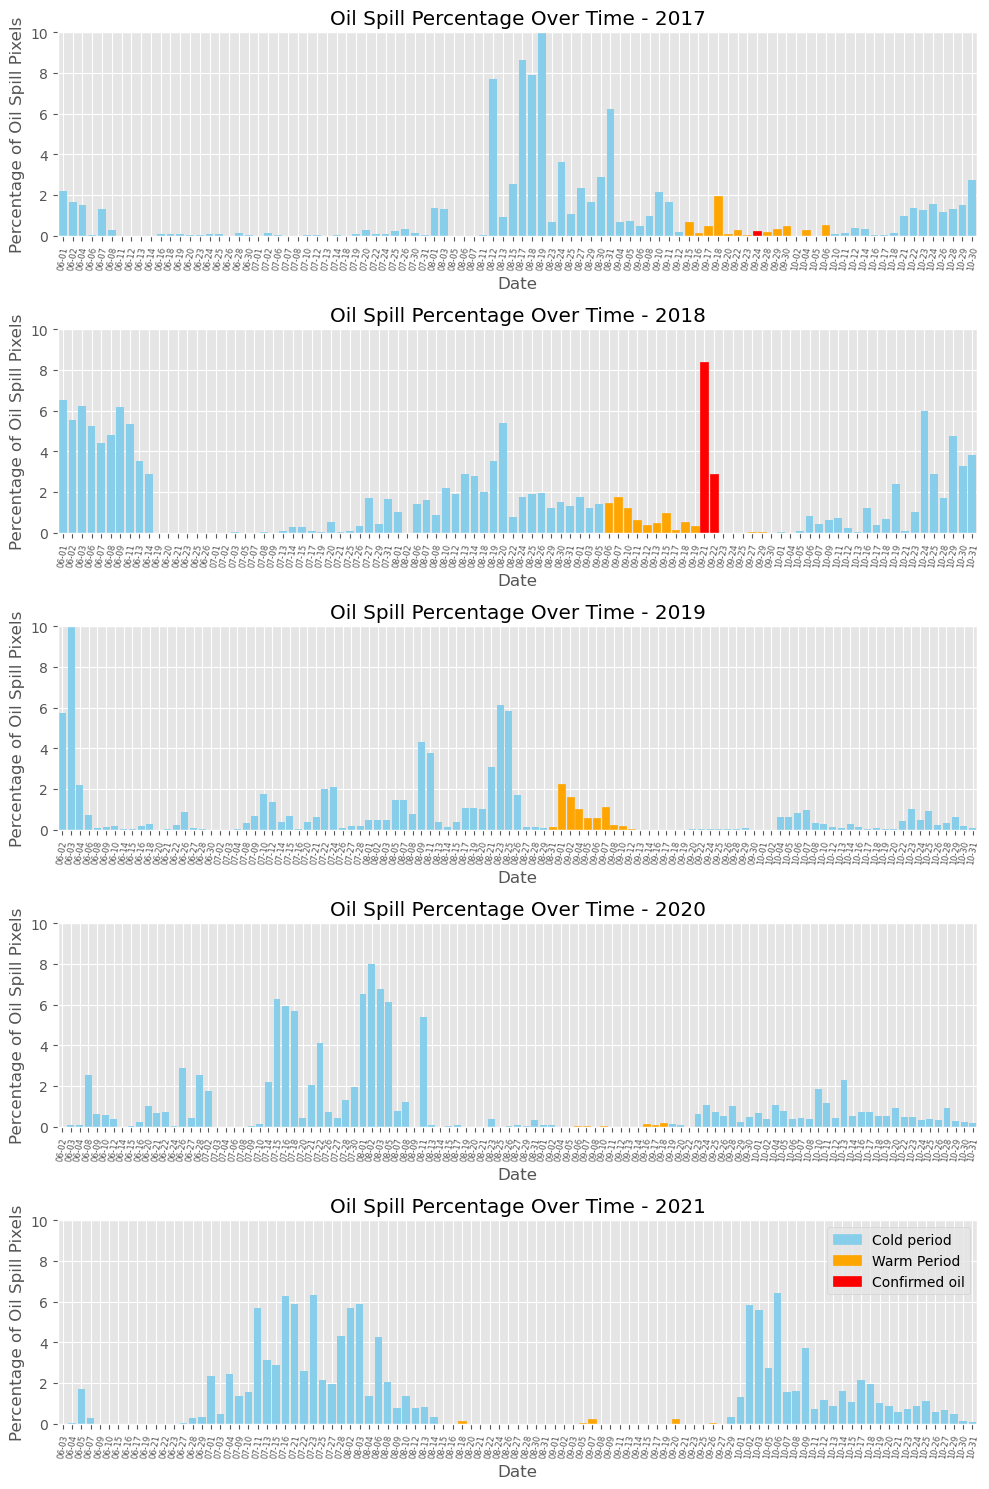

<Figure size 640x480 with 0 Axes>

In [245]:
####### PLOTTING OF VISUALIZATIONS ######## Parameters
IMFolder = "C:/Users/Mr. Oliver/Desktop/CNN/FinalModels/UNet/output/test/HHdb_2017-21_n11"

NumIm = 4
iMPaths = np.array(sorted(list(paths.list_images(os.path.join(file_path,config.train_image)))))
#imagePaths = ('C:/Users/Mr. Oliver/Desktop/CNN/FinalModels/DeepLabV3/dataset/test/images/img_0001.jpg','C:/Users/Mr. Oliver/Desktop/CNN/FinalModels/DeepLabV3/dataset/test/images/img_0061.jpg','C:/Users/Mr. Oliver/Desktop/CNN/FinalModels/DeepLabV3/dataset/test/images/img_0066.jpg', 'C:/Users/Mr. Oliver/Desktop/CNN/FinalModels/DeepLabV3/dataset/test/images/img_0069.jpg')
imagePaths = np.random.choice(iMPaths, size = NumIm)
badimpathsu = [ 'c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0052.jpg',
 'c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0415.jpg',
 'c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0990.jpg',
 'c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0864.jpg',
 'c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0613.jpg']
goodimpathsu = ['c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0587.jpg',
                'c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0989.jpg',
 'c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0635.jpg',
 'c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0260.jpg',
 'c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0957.jpg']
Predtest_paths = ["C:/Users/Mr. Oliver/Desktop/CNN/FinalModels/UNet/output/test/HHdb_2023_n1"]
#print(imagePaths)
imagePaths = goodimpathsu
#model = torch.load(os.path.join(file_path, config.model)).to(config.device)
model = torch.load('c:/Users/Mr. Oliver/Desktop/CNN/FinalModels/DeepLabV3/output/28/unet_oil.pth').to(config.device)
TestOnHH = True
#Highlights = ["2023-02-07", "2023-07-13", "2023-10-27"]
#Highlights = ["2023-09-28"]
HighlightsVV = ["2018-05-22", "2018-06-03", "2018-06-15", "2018-07-03", "2018-08-08",
              "2018-09-19", "2019-05-17", "2019-07-16", "2019-07-28", "2019-08-09",
              "2019-10-02", "2019-10-26", "2020-06-04", "2020-07-28", "2020-11-01",
              "2021-02-05", "2021-03-19", "2021-03-31", "2021-06-29", "2021-07-17",
              "2021-07-23", "2021-08-28", "2021-10-15"]
HighlightsHH = ["2018-05-22", "2018-06-03", "2018-06-15", "2019-01-05", "2019-04-23",
                "2019-07-16", "2019-08-03", "2019-08-09", "2019-09-08", "2019-10-02",
                "2019-10-08", "2019-11-15", "2019-11-25", "2020-04-17", "2020-04-17",
                "2020-06-04", "2020-07-28", "2020-08-15", "2020-09-02", "2020-09-26",
                "2021-02-17", "2021-05-18", "2021-06-29", "2021-07-05", "2021-08-28",
                "2021-09-03", "2021-10-15", "2021-12-20"]
Highlights = [HighlightsVV, HighlightsHH]
Highlights = ["2017-09-19", "2018-09-21", "2017-09-24", "2018-09-22"]
Ice = [["2017-09-15", "2018-09-06", "2019-08-31", "2020-09-05", "2021-08-15"], ["2017-10-06", "2018-09-29", "2019-09-17", "2020-09-18", "2021-09-27"]]
#########################################################################

if TestOnHH == True:
    #Test_HH_pred()
    TemporalPredict(IMFolder, model, Highlights=Highlights, Ice=Ice)

else:
    it = 0
    xlist, ylist, predlist, conflist = [], [], [], []

    for path in imagePaths:
        #print(it)
        x, y, pred, conf = make_predictions(model, path)
        xlist.append(x)
        ylist.append(y)
        predlist.append(pred)
        conflist.append(conf)
    
    prepare_plot(xlist, ylist, predlist, conflist)

0.6762375
41
tensor([0.9451, 0.5774, 0.5232, 0.4011, 0.9343], device='cuda:0')
[0.39632612 0.5092705  0.57963896 0.62666947 0.6301289  0.6083118
 0.6261951 ]
[[9.0520608e-01 2.7593786e-01 2.5022605e-01 2.0048115e-04 5.5006009e-01]
 [9.1650313e-01 4.0031752e-01 3.2925299e-01 1.5145142e-01 7.4882734e-01]
 [9.4160777e-01 4.0377569e-01 3.8147801e-01 2.9728332e-01 8.7404978e-01]
 [9.4741803e-01 5.4161477e-01 4.2156133e-01 3.4080467e-01 8.8194847e-01]
 [9.4426471e-01 5.3498060e-01 4.0308207e-01 3.5096741e-01 9.1734982e-01]
 [9.4752848e-01 5.2671790e-01 4.2116070e-01 2.6076773e-01 8.8538373e-01]
 [9.4799775e-01 5.3330976e-01 4.5248365e-01 2.7661857e-01 9.2056561e-01]]


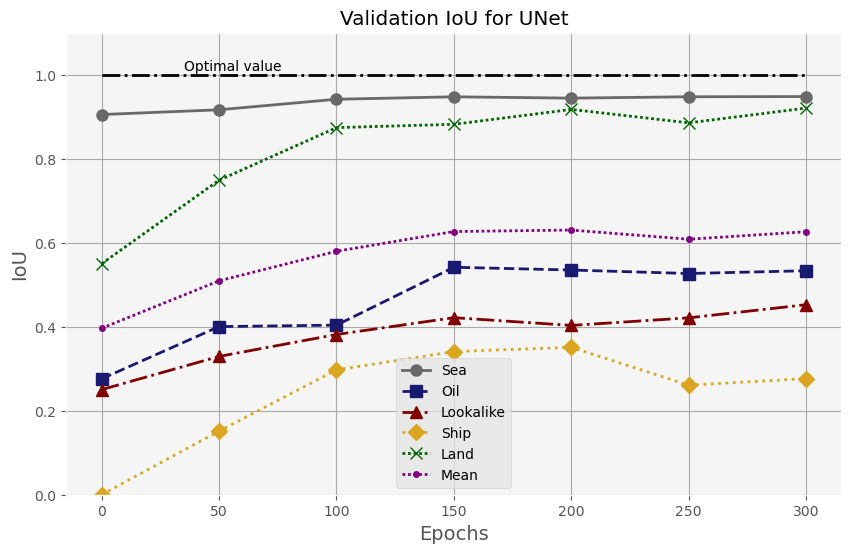

[0.40761667 0.5371564  0.5836481  0.6344448  0.6495609  0.64785945
 0.63892996]
[[0.91358453 0.31015053 0.26044494 0.013745   0.5401584 ]
 [0.93572533 0.41039905 0.36054048 0.20115025 0.77796686]
 [0.9434964  0.45563087 0.41036025 0.26670155 0.8420515 ]
 [0.95133305 0.5164024  0.4892769  0.31947753 0.89573383]
 [0.9537999  0.5385207  0.51082355 0.33823133 0.9064294 ]
 [0.9536109  0.5269966  0.50943416 0.33487108 0.9143847 ]
 [0.9517911  0.53815943 0.4952469  0.3031238  0.90632874]]


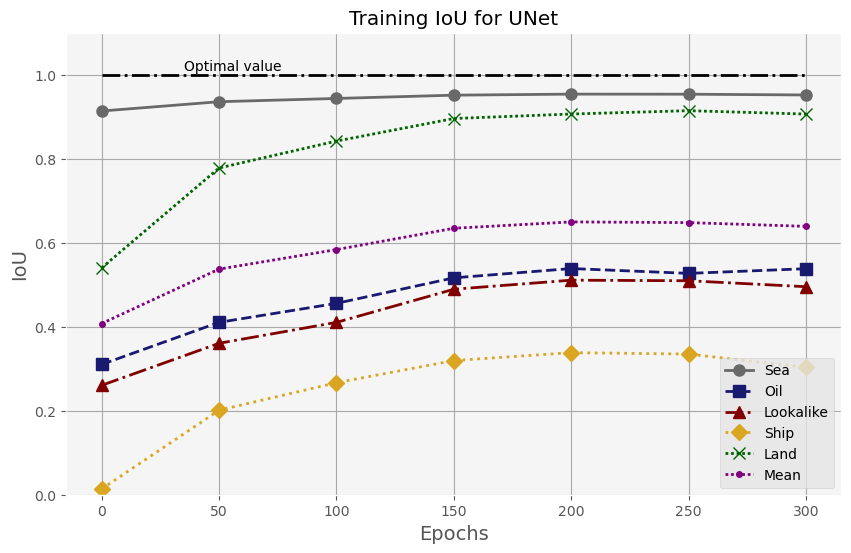

[0.50054747 0.6271164  0.66139305 0.72269857 0.73090285 0.7115644
 0.70941544]
[[9.4607699e-01 3.2754874e-01 4.0065163e-01 2.0048115e-04 8.2825947e-01]
 [9.5308781e-01 4.8095948e-01 5.0512397e-01 2.3820034e-01 9.5821035e-01]
 [9.7785711e-01 4.6845779e-01 5.1380897e-01 3.9900628e-01 9.4783515e-01]
 [9.7728741e-01 6.3384122e-01 5.6338495e-01 4.9471402e-01 9.4426519e-01]
 [9.7562140e-01 6.2569529e-01 5.4294384e-01 5.3599894e-01 9.7425520e-01]
 [9.8136795e-01 6.0970795e-01 5.4287016e-01 4.9668851e-01 9.2718774e-01]
 [9.8113376e-01 6.2917632e-01 5.6220227e-01 4.1375256e-01 9.6081227e-01]]


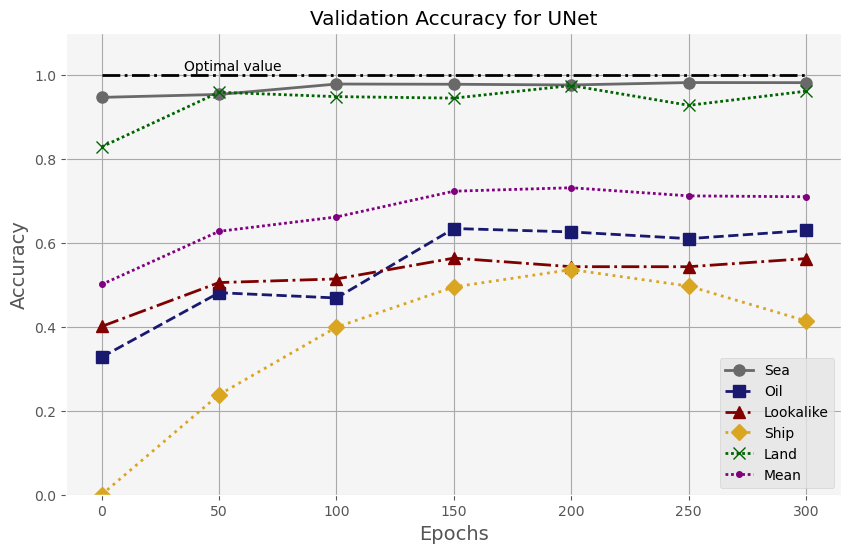

[0.46991354 0.6074432  0.65479374 0.7037614  0.7189518  0.7144567
 0.7061137 ]
[[0.97603047 0.39273152 0.32197696 0.01425977 0.6445689 ]
 [0.9794361  0.5045458  0.45038623 0.23732352 0.8655243 ]
 [0.9819196  0.5544375  0.50429577 0.32429677 0.9090191 ]
 [0.98330784 0.6141865  0.59605414 0.38296005 0.9422984 ]
 [0.9844052  0.63765824 0.613842   0.4125018  0.9463517 ]
 [0.98447514 0.618694   0.6121634  0.40256372 0.95438707]
 [0.9845285  0.63458115 0.5931793  0.37532762 0.942952  ]]


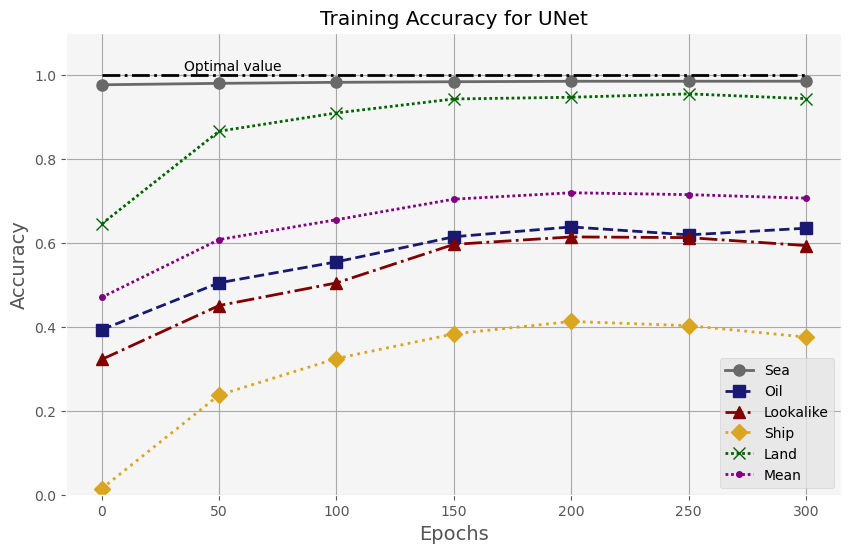

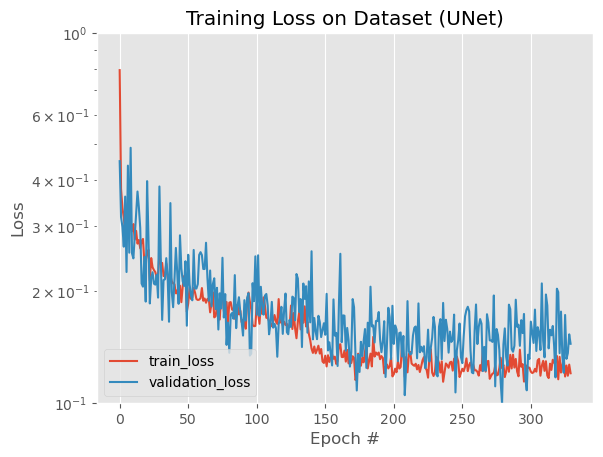

<Figure size 640x480 with 0 Axes>

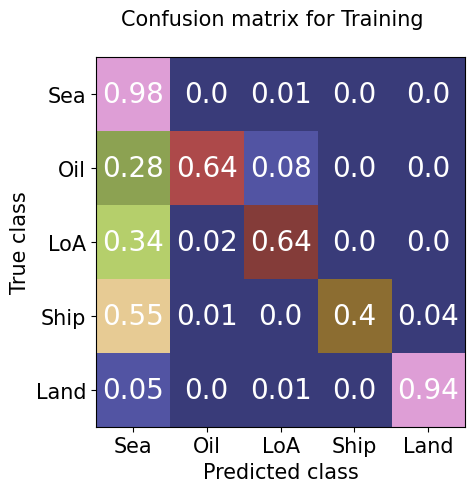

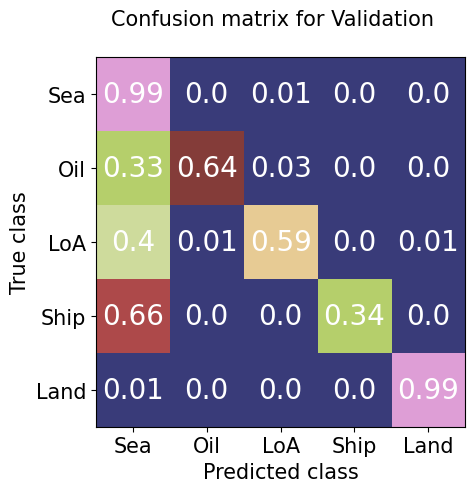

In [246]:
#Requires cleanup

"""
            H["metrics_validation"].append(metric_validation.compute())
            H["accuracy_validation"].append(AccuracyMetric_validation.compute())
            H["metrics_train"].append(metric_train.compute())
            H["accuracy_train"].append(AccuracyMetric_train.compute())
            H["ConfusionTrain"].append(ConfusionMatrixTrain.compute())
            H["ConfusionValidation"].append(ConfusionMatrixValidation.compute())
        pd.DataFrame.from_dict
"""
metric_train = JaccardIndex(task="multiclass", num_classes=5, average=None).to("cuda")
metric_validation = JaccardIndex(task="multiclass", num_classes=5, average=None).to("cuda")
AccuracyMetric_train = MulticlassAccuracy(num_classes=5, average=None).to("cuda")
AccuracyMetric_validation = MulticlassAccuracy(num_classes=5, average=None).to("cuda")
ConfusionMatrixTrain = MulticlassConfusionMatrix(num_classes=5, normalize="true").to("cuda")
ConfusionMatrixValidation = MulticlassConfusionMatrix(num_classes=5, normalize="true").to("cuda")
file_path = 'c:/Users/Mr. Oliver/Desktop/CNN/DeepLabV3/output'

T = False
if T == True:
    file_path = 'c:/Users/Mr. Oliver/Desktop/CNN/ResnetUNet/output'
    H1 = pd.read_pickle(os.path.join(file_path, "15.5", "H.pkl"))
    #print(len(H1["train_loss"]))
    H2 = pd.read_pickle(os.path.join(file_path, "16/H.pkl"))
    print(len(H2["train_loss"]))
    H3 = pd.read_pickle(os.path.join(file_path, "17/H.pkl"))
    print(len(H3["train_loss"]))
    H4 = pd.read_pickle(os.path.join(file_path, "18/H.pkl"))
    print(len(H4["train_loss"]))
    H5 = pd.read_pickle(os.path.join(file_path, "19 final/H.pkl"))
    print(len(H5["train_loss"]))
    H6 = pd.read_pickle(os.path.join(file_path, "20.5/H.pkl"))
    print(len(H6["train_loss"]))
    H7 = pd.read_pickle(os.path.join(file_path, "21/H.pkl"))
    print(len(H7["train_loss"]))
    H8 = pd.read_pickle(os.path.join(file_path, "22/H.pkl"))
    print(len(H8["train_loss"]))
    H9 = pd.read_pickle(os.path.join(file_path, "22.5/H.pkl"))
    print(len(H9["train_loss"]))
    H10 = pd.read_pickle(os.path.join(file_path, "23.5/H.pkl"))
    print(len(H10["train_loss"]))
    
else:
    file_path = 'c:/Users/Mr. Oliver/Desktop/CNN/FinalModels/UNet/output'
    H1 = pd.read_pickle(os.path.join(file_path, "0/H.pkl"))
    H2 = pd.read_pickle(os.path.join(file_path, "1/H.pkl"))
    H3 = pd.read_pickle(os.path.join(file_path, "2/H.pkl"))
    H4 = pd.read_pickle(os.path.join(file_path, "3/H.pkl"))
    H5 = pd.read_pickle(os.path.join(file_path, "4/H.pkl"))
    H6 = pd.read_pickle(os.path.join(file_path, "5/H.pkl"))
    #H7 = pd.read_pickle(os.path.join(file_path, "6/H.pkl"))
    #H8 = pd.read_pickle(os.path.join(file_path, "7/H.pkl"))
    #H9 = pd.read_pickle(os.path.join(file_path, "8/H.pkl"))


#H = dict_combine(H1, H2) #off
#H = dict_combine(H, H3) 
#H = dict_combine(H, H4) #off
#H = dict_combine(H, H4)
#H = dict_combine(H, H5)
#H = dict_combine(H, H6)
#H = dict_combine(H, H7)
#H = dict_combine(H, H8)
#H = dict_combine(H, H9) #off
#H = dict_combine(H, H10) #off

file_path = 'c:/Users/Mr. Oliver/Desktop/CNN/FinalModels/UNet/output/10'
H = pd.read_pickle(os.path.join(file_path, "H.pkl"))
maxmean = 0
i = 0
argmas = 0
for iou in H["metrics_validation"]:
    i += 1
    if maxmean == 0:
        maxmean = np.mean(iou.cpu().numpy())
    elif np.mean(iou.cpu().numpy()) > maxmean:
        maxmean = np.mean(iou.cpu().numpy())
        argmas = i
print(maxmean)
print(argmas)
print(H["metrics_validation"][argmas-1])
#Datamanagement
H_fixed = {"train_loss": [],
            "test_loss": [],
            "metrics_validation": [],
            "metrics_train": [],
            "accuracy_validation": [],
            "accuracy_train": [],
            "ConfusionTrain": [],
            "ConfusionValidation": []}

H_fixed["metrics_validation"] = to_numpy_plot(H["metrics_validation"])
H_fixed["metrics_train"] = to_numpy_plot(H["metrics_train"])
H_fixed["accuracy_validation"] = to_numpy_plot(H["accuracy_validation"])
H_fixed["accuracy_train"] = to_numpy_plot(H["accuracy_train"])

plot_data(H_fixed["metrics_validation"], ylabel='IoU', title='Validation IoU for UNet')
plot_data(H_fixed["metrics_train"], ylabel='IoU', title='Training IoU for UNet')
plot_data(H_fixed["accuracy_validation"], ylabel='Accuracy', title='Validation Accuracy for UNet')
plot_data(H_fixed["accuracy_train"], ylabel='Accuracy', title='Training Accuracy for UNet')

# Plotting
plt.style.use("ggplot")
plt.figure()

# Plotting loss
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="validation_loss")
plt.ylim(10e-2,1)
plt.yscale("log")
plt.title("Training Loss on Dataset (UNet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

# Plotting metrics and accuracy
plt.figure()
#fig1, ax1 = metric_validation.plot(H_fixed["metrics_validation"])
#fig2, ax2 = AccuracyMetric_validation.plot(H["accuracy_validation"])
#fig3, ax3 = metric_train.plot(H["metrics_train"])
#fig4, ax4 = AccuracyMetric_train.plot(H["accuracy_train"])
fig5, ax5 = ConfusionMatrixTrain.plot(H["ConfusionTrain"][-1], fontsize=15, labels=['Sea', 'Oil', 'LoA', 'Ship', 'Land'], title="Confusion matrix for Training")
fig6, ax6 = ConfusionMatrixValidation.plot(H["ConfusionValidation"][-1], fontsize=15, labels=['Sea', 'Oil', 'LoA', 'Ship', 'Land'], title="Confusion matrix for Validation")

<Figure size 640x480 with 0 Axes>

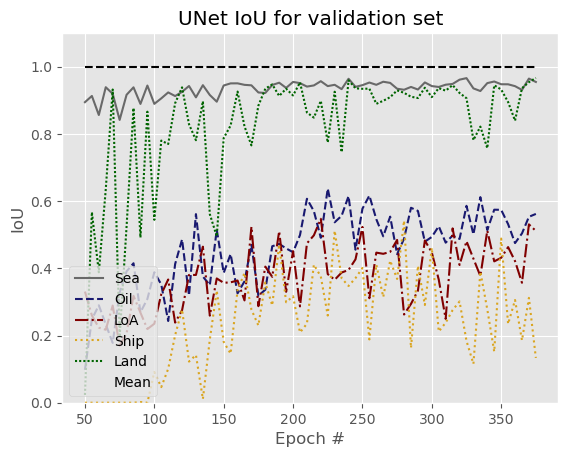

<Figure size 640x480 with 0 Axes>

In [247]:
plottablevalues = []
for i in H["metrics_validation"]:
    temp = []
    for e in i:
        temp.append(np.float32(e.cpu().numpy()))
    temp.append(np.mean(i.cpu().numpy()))
    plottablevalues.append(temp)

colors = ['dimgray', 'midnightblue', 'maroon', 'goldenrod', 'darkgreen', 'purple']
linestyles = ['-', '--', '-.', ':', (0, (1, 1)), (1, (0, 1))]
labels=["Sea", "Oil", "LoA", "Ship", "Land", "Mean"]
for i in range(len(colors)):
    plt.plot(np.array(plottablevalues)[:].T[i], label=labels[i], color=colors[i], linestyle=linestyles[i])
xticks_positions, _ = plt.xticks()
plt.ylim(0,1.1)
#plt.yscale("log")
plt.title("UNet IoU for validation set")
plt.xlabel("Epoch #")
plt.ylabel("IoU")
plt.xticks(xticks_positions, labels=["450", "50", "100", "150", "200", "250", "300", "350", "400"])
plt.legend(loc="lower left")
plt.plot(np.ones(len(plottablevalues)), label="Optimal value", color="black", linestyle="--")
# Plotting metrics and accuracy
plt.figure()